In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# ==============================
# 1. Carregar e preparar os dados
# ==============================
df = pd.read_csv("Data/Order_Agg.csv").sort_values("AccountId")
df = pd.get_dummies(df[df['TotalPrice'] > 0], columns=['ProductLine'])

In [2]:
#Novas Colunas
df["RelativePrice"] = df["AvgPrice"] / (df.groupby("AccountId")["AvgPrice"].transform("mean") + 1e-9)
df["GlobalPopularity"] = df.groupby("ProductCode")["HasOrder"].transform("sum")
df["CustomerDiversity"] = df.groupby("AccountId")["ProductCode"].transform("nunique")

In [3]:
# Label: HasOrder (0, 1, 2)
y = df["HasOrder"].fillna(0).astype(int)

# Features atuais + possibilidade de novas features
feature_cols = [
    'TotalPrice',
    'AvgPrice',
    'TotalQuantity',
    'AvgQuantity',
    'Recency',
    'AvgRecency',
    'ProductPopularity',
    'TotalPriceProportion',
    'TotalQuantityProportion',
    'OrderCount',
    'Frequency',
    'RelativePrice',
    'GlobalPopularity',
    'CustomerDiversity'
]

# 🔹 Aqui você pode adicionar mais informações do produto
# Exemplo: peso, tamanho, categoria codificada, etc.
extra_features = [c for c in df.columns if c in ['Weight'] or c.startswith('ProductLine')]
feature_cols.extend(extra_features)

X = df[feature_cols]

In [4]:
# ==============================
# 2. Split por AccountId (sem vazar info)
# ==============================
unique_accounts = df["AccountId"].unique()
train_ids, test_ids = train_test_split(unique_accounts, test_size=0.2, random_state=42)

train_df = df[df["AccountId"].isin(train_ids)]
test_df  = df[df["AccountId"].isin(test_ids)]

X_train, y_train = train_df[feature_cols], train_df["HasOrder"].astype(int)
X_test, y_test   = test_df[feature_cols],  test_df["HasOrder"].astype(int)

# Grupos por conta (cada cliente é um grupo de produtos)
train_groups = train_df.groupby("AccountId").size().to_list()
test_groups  = test_df.groupby("AccountId").size().to_list()

train_data = lgb.Dataset(X_train, label=y_train, group=train_groups)
test_data  = lgb.Dataset(X_test, label=y_test, group=test_groups, reference=train_data)

In [5]:
# ==============================
# 3. Hiperparâmetros otimizados
# ==============================
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [5, 10],   # Avaliação no top-5 e top-10
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbosity": -1
}

In [6]:
# ==============================
# 4. Treinamento
# ==============================
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=["train", "valid"],
    num_boost_round=1000,
    #early_stopping_rounds=50
)

In [7]:
# ==============================
# 5. Predição e Ranking em um cliente específico
# ==============================
account_id = '0018c00002SwxD0AAJ'

X_new = df[df['AccountId'] == account_id][feature_cols]
product_ids = df[df['AccountId'] == account_id]['ProductCode'].to_list()

scores = model.predict(X_new)

ranking = sorted(zip(product_ids, scores), key=lambda x: x[1], reverse=True)

print(f"\nRanking de produtos recomendados para Account {account_id}:")
for prod, score in ranking:
    print(f"Produto {prod} - score {score:.4f}")


Ranking de produtos recomendados para Account 0018c00002SwxD0AAJ:
Produto 77303543 - score -6.5278
Produto 77704432 - score -6.6995
Produto 78506750 - score -6.7687
Produto 77200654 - score -6.7688
Produto 77218754 - score -7.0424
Produto 77459534 - score -7.0424
Produto 40370020 - score -7.1284
Produto 77559524 - score -7.2621
Produto 77819051 - score -7.2722
Produto 77600615 - score -7.7750
Produto 77855764 - score -7.7926
Produto 40370018 - score -7.7926
Produto 77395085 - score -7.8165
Produto 78502750 - score -7.8165


/home/vitor/Documents/Unisinos/TCC/TCC_VITOR_H_SPADER/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


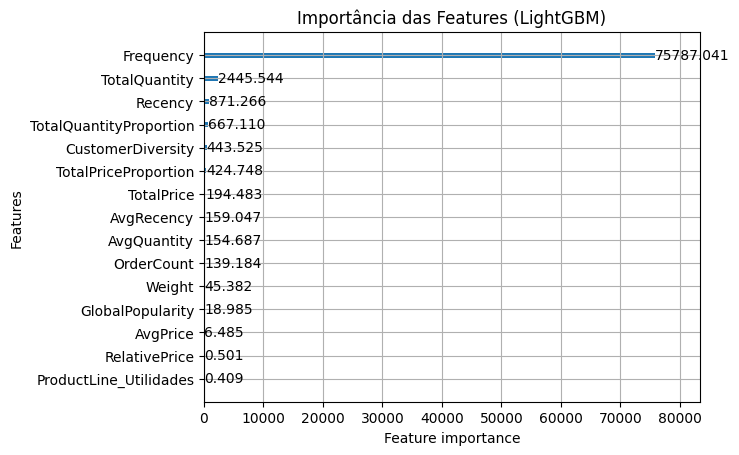

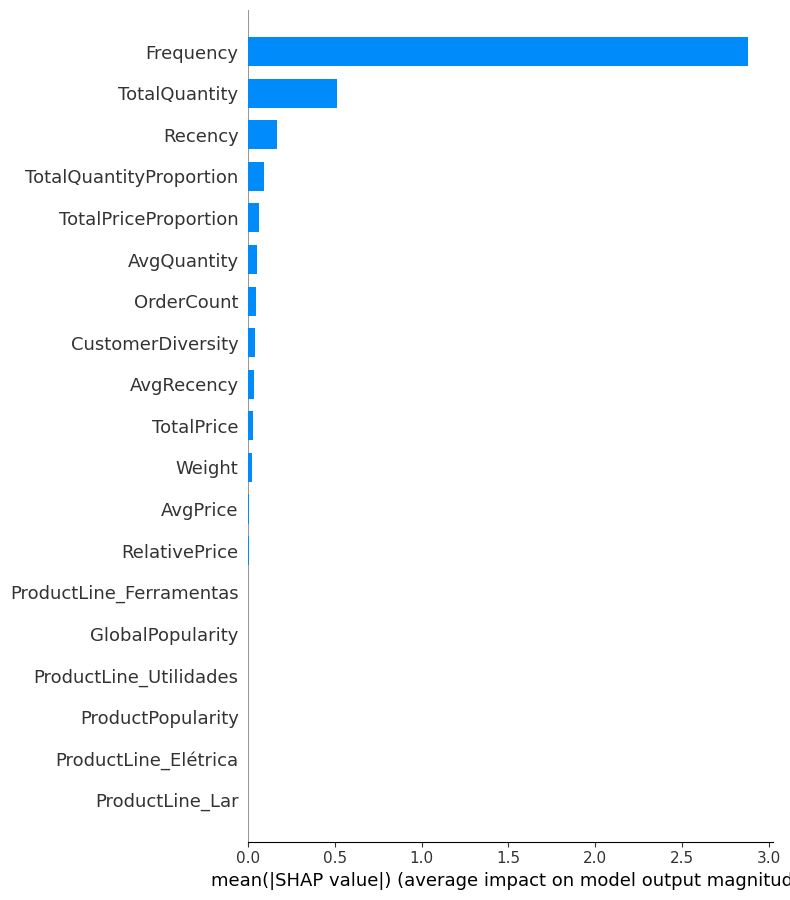

In [8]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

# ==============================
# 1. Importância das Features
# ==============================
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.title("Importância das Features (LightGBM)")
plt.show()

# ==============================
# 2. Explicação com SHAP
# ==============================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Gráfico resumido: mostra as variáveis que mais influenciam no ranking
shap.summary_plot(shap_values, X_test, plot_type="bar")